
# Модель с нулевым раздутием (Zero inflated model)


Метод максимального правдоподобия позволяет нам оценивать не только классические модели вроде линейной или логистической регрессии. Он позволяет нам специфицировать произвольную модель, которая на наш взгляд подходит для данных. Именно такую модель мы с вами и оценим.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Иногда так бывает, что в той переменной, которую мы собираемся прогнозировать, встречается очень много нулей. Представим себе, что биологи хотят смоделировать, сколько рыбы ловят отдахающие в национальном парке, когда выезжают туда с палатками. Понятное дело, что подавляющее большинство не будет ловить рыбу. Из-за этого в данных будет довольно много нулей. 

## Описание данных 

В парке отдыхало $250$ групп туристов. Каждой группе был задан вопрос о том, сколько рыбы они поймали `count`. В каждой группе посчитали число детей `child`, число людей `persons`. Каждой группе отдыхающих задавали вопрос: приехали ли они с палатками `camper`. 

Колонки с координатами и информацией о ловле на живца нас интересовать не будут. Их мы удалим. 

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Math & Natural & Finance/Math/Statistics/data/fish.tsv", sep='\t')
df.drop(['xb', 'zg', 'livebait'], axis=1, inplace=True)
df.head()

,nofish,camper,persons,child,count
0,1,0,1,0,0
1,0,1,1,0,0
2,0,0,1,0,0
3,0,1,2,1,0
4,0,0,1,0,1


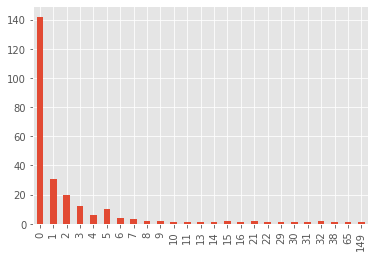

In [4]:
df['count'].value_counts().sort_index(ascending=True).plot(kind='bar');

Видно, что в данных о пойманной рыбе нули встречаются чаще всего. Специфичные данные требуют специфичных моделей. Будем предполагать, что:

- Число пойманной рыбы имеет распределение Пуассона 
- Вероятность того, что группа туристов не поймала ни одной рыбы моделируется отдельно

## Модель

----------------

Предпримем первую попытку построить [zero inflated model.](https://en.wikipedia.org/wiki/Zero-inflated_model) Этот пункт решён за вас. Разберитесь в том, как именно мы выводим модель.

__Цель:__ вытащить нулевое значение и вероятность для него в отдельный параметр. 

__Делай раз:__  мы хотим, чтобы распределение Пуассона для нас работало, начиная с $X = 1$. В таком случае нам его надо сдвинуть вправо так, чтобы сумма вероятностей по-прежнему оставалась равна единице. Мы знаем, что 

$$
\sum_{k=0}^{\infty} P(X = k) = \sum_{k=0}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = e^{-\lambda} + \sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = 1.
$$

Если мы решим оставить только сумму, начиная с единицы, получится, что 

$$
\sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} = 1 - e^{-\lambda}.
$$

Чтобы перед нами было полноценное распределение и все вероятности в сумме давали $1$, нам надо поделить сумму слева на $1 - e^{-\lambda}$. Получается, что для распределения Пуассона, обрезанного со стороны нуля, формула для поиска вероятности выглядить как 

$$
P(X = k \mid X > 0) = \frac{1}{1 - e^{-\lambda}} \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
$$

Можно получить эту формулу исходя не из интуции, а из формулы условной вероятности:

$$
P(X = k \mid X > 0) = \frac{P(X = k \cap X > 0)}{P(X > 0)} = \frac{\frac{\lambda^k e^{-\lambda}}{k!}}{1 - e^{-\lambda}}
$$


__Делай два:__ Теперь давайте построим смесь из двух распределений. Случайная величина $X$ будет принимать с вероятностью $p$ значение $0$, и с вероятностью $1 - p$ будет распределена по Пуассону со сдвигом: 

$$
\begin{aligned}
& P(X = 0) = p \\
& P(X = k) = (1 - p) \cdot \frac{1}{1 - e^{-\lambda}} \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
\end{aligned}
$$

Построенная модель — это ещё не совсем то, что нам надо. У такой формулировки модели есть минус. Невозможно проверить гипотезу о том, что в нуле нет никаких особенностей. Если $p = 0$, то у нас просто-напросто не бывает нулевых значений, а нам надо при $p=0$ получить обычное распределение Пуассона. 

__Итоговая модель:__ Хочется, чтобы у нас была возможность протестировать такую гипотезу. Для этого ноль выносится в отдельную категорию не в результате обрезания распределения Пуассона, а немного иначе.  

Давайте домножим $P(X = k)$ на $(1-p)$, а потом просто вынесем $(1 - p) \cdot P(X = 0)$ в отдельное слагаемое. И тогда получится модель: 

$$
\begin{aligned}
& P(X = 0) = p + (1 - p) \cdot e^{-\lambda} \\
& P(X = k) = (1 - p) \cdot \frac{\lambda^k e^{-\lambda}}{k!}.
\end{aligned}
$$ 

Если $p=0$, то у нас получается распределение Пуассона. У нас возникает возможность проверить гипотезу $H_0$, состояшую в том, что в нуле нет никакого особого значения. Распределение Пуассона оказывается вложено в нашу более сложную модель в лучших традициях частотной статистики. 

----------------

## Функция потерь

Выпишите на бумажке логарифмическую функцию правдоподобия для Zero Inflated Model. Вбейте её в python.

__Hint:__ Множителем $\frac{1}{y_1! \cdot \ldots \cdot y_n!}$ нужно пренебречь. Он не влияет на оптимизацию функции. Очень удобно будет выписать функцию правдоподобия для одного наблюдения, а затем аккуратно усложнять её в следующих пунктах. Векторный `numpy` позволит удобно с ней работать. 

* $L = \left\{
    \begin{array}\\
        += p + (1-p)e^{-\lambda}, \space k = 0\\
        += (1-p)\dfrac{\lambda ^ k e^{-\lambda}}{k!}, \space else 
    \end{array} 
  \right. $  
* $ logL = \left\{
    \begin{array}\\
        += log(p + (1-p)e^{-\lambda}), \space k = 0\\
        += log(1-p) - \lambda + k \cdot log(\lambda), \space else 
    \end{array} 
  \right. $  
  
  **PS:** пренебрежём логарифмом факториала

In [5]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
import math

def lnL(theta, data):
    p = np.exp(theta[0])/(1 + np.exp(theta[0]))  # приём, чтобы p всегда был от 0 до 1
    lam = np.exp(theta[1])                       # приём, чтобы lam всегда был больше 0
    
    # your code here
    logL = 0
    size = len(data)
    for ind in df.index:
      k = df['count'][ind]
      if k == 0:
        logL += math.log(p + (1-p)*math.exp(-lam))
      else:
        logL += math.log(1-p) - lam + k*math.log(lam)
    return -logL

In [6]:
assert np.abs(lnL([0.2, 0.2], df) - 107.543) < 1e-4
assert np.abs(lnL([0, 0], df) - 236.8036) < 1e-4
assert np.abs(lnL([1,1], df) - -347.5161) < 1e-4

## Оценка параметров

Оцените для случайной величины $Y$ (число пойманной рыбы) параметры $p$ и $\lambda$ методом максимального правдоподобия. 

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

# your code here
import scipy
from scipy.optimize import minimize

theta_init = [0.5, 0.1]
res = minimize(fun=lnL, x0=theta_init, args=df)

In [8]:
res

      fun: -679.485351966023
 hess_inv: array([[0.00464747, 0.00094505],
       [0.00094505, 0.00121275]])
      jac: array([3.05175781e-05, 5.34057617e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 138
      nit: 11
     njev: 42
   status: 2
  success: False
        x: array([0.27283663, 2.03155151])

In [9]:
assert np.abs(res.fun + 679) < 1
assert np.abs(res.x[0] - 0.27) < 1e-2
assert np.abs(res.x[1] - 2.03) < 1e-2

Сравним получившееся значение $\hat{p}^{ML}$ с частотой нулей в данных. 

In [10]:
round(np.exp(res.x[0])/(1 + np.exp(res.x[0])), 3)

0.568

In [11]:
np.mean(df['count'] == 0)

0.568

Совпало. Мы предположили выше, что $Y=0$ формируются независимо от остальной части, поэтому значение $p$ таким и получилось. Оценка $\hat{\lambda}^{ML}$ совпадет со средним, посчитанным по всем $y_i > 0$. 

In [12]:
np.exp(res.x[1])

7.625908874353213

In [13]:
df['count'][df['count'] > 0].mean()

7.62962962962963

Для такой простой постановки можно решить задачу на листочке. Найдите оценки $\hat{\lambda}^{ML}$ и $\hat{p}^{ML}$ в явном виде.

* $Y=0$ формируются независимо от остальной части:  
$$\dfrac{\partial L}{\partial \lambda} = - N_{y > 0} + \dfrac{\sum_{j=1}^{N_{y > 0}}k_j}{\hat\lambda} = 0 $$
$$\hat\lambda = \dfrac{\sum_{j=1}^{N_{y > 0}}k_j}{N_{y > 0}}$$



## Тест отношения правдоподобий

Проверьте с помощью теста отношения правдоподобий на уровне значимости $1\%$ гипотезу о том, что $p=0$. Если эта гипотеза не отвергается, то мы зря усложнили наше распределение. 

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

def lnL_R(theta, data):
    p = 0
    lam = np.exp(theta)
    
# your code here
    logL_R = 0
    size = len(data)
    for ind in df.index:
      k = df['count'][ind]
      if k == 0:
        logL_R += math.log(p + (1-p)*math.exp(-lam))
      else:
        logL_R += math.log(1-p) - lam + k*math.log(lam)
    return -logL_R

theta_init = [0.5, 0.1]
res = minimize(fun=lnL, x0=theta_init, args=df)

In [15]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

res_R =  minimize(fun=lnL_R, x0=res.x[1], args=df)
lnL_un = lnL(res.x, df)
lnL_r =  res_R.fun

LR_obs = -2*(lnL_un-lnL_r) #minus sign bofore the expression
LR_cr = scipy.stats.chi2.ppf(1-0.01, df=1)

In [16]:
assert np.abs(lnL_r - -158.79) < 1e-2
assert np.abs(lnL_un - -679.48) < 1e-2
assert np.abs(LR_obs - 1041.38) < 1e-2
assert np.abs(LR_cr - 6.63) < 1e-2

## Линейная модель

Поднимаем ставки. До этого мы смотрели на число пойманной рыбы как на отдельную случайную величину, которая ни от чего не зависит. Давайте усложним ситуацию. Пусть интенсивность пойманной рыбы объясняется другими факторами, то есть:

$$
\lambda_i =  \exp(\beta_0 + \beta_1 \cdot child_i + \beta_2 \cdot persons_i + \beta_3 \cdot camper_i).
$$

Это звучит логично, если у нас есть палатка, нас в группе много, то и рыбы мы будем ловить много. Экспонента здесь используется, чтобы параметр $\lambda_i$ всегда был положительным. 

Выпишите для такой модели логарифмическое правдоподобие, вбейте его в python и оцените параметры $\beta_0, \beta_1, \beta_2, \beta_3, p$. Удобнее всего будет вбивать его в матричном виде. 

In [24]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

def lnL(theta, data):
    p = np.exp(theta[0])/(1 + np.exp(theta[0]))
    b = theta[1:]
    
# your code here
    logL_b = 0
    size = len(data)
    for ind in df.index:
      k = df['count'][ind]
      child = df['child'][ind]
      persons = df['persons'][ind]
      camper = df['camper'][ind]
      lam = math.exp(np.dot(b, [1, child, persons, camper]))
      if k == 0:
        logL_b += math.log(p + (1-p)*math.exp(-lam))
      else:
        logL_b += math.log(1-p) - lam + k*math.log(lam)
    return -logL_b

In [25]:
par = np.hstack((0.5, np.ones(4)))
assert np.abs(lnL(par, df) - 27323.49) < 1e-2

In [26]:
theta_init = np.hstack((0.5, np.ones(4)))
res = minimize(lnL, theta_init, args=df)
res

      fun: -1030.0420857288132
 hess_inv: array([[ 9.86690176e-02,  1.02890075e-03, -3.13451171e-02,
         7.85554147e-03, -2.56858960e-02],
       [ 1.02890075e-03,  3.17756544e-05, -2.93037827e-04,
         5.00874657e-05, -2.66423574e-04],
       [-3.13451171e-02, -2.93037827e-04,  1.00705753e-02,
        -2.54247369e-03,  8.11557693e-03],
       [ 7.85554147e-03,  5.00874657e-05, -2.54247369e-03,
         7.45621358e-04, -2.10193691e-03],
       [-2.56858960e-02, -2.66423574e-04,  8.11557693e-03,
        -2.10193691e-03,  6.79827332e-03]])
      jac: array([ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, -4.57763672e-05,
       -7.62939453e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 282
      nit: 26
     njev: 47
   status: 2
  success: False
        x: array([-0.36585137, -0.99805186, -1.36091061,  0.87214208,  0.79560953])

In [27]:
assert np.abs(res.x[0] - -0.3658) < 1e-4
assert np.abs(res.x[-1] - 0.7956) < 1e-4

## Линейная модель-2

__е)__ Поднимаем ставки ещё выше. Скрестим нашу модель с логистической регрессией. Пусть не только интенсивность пуассоновского потока зависит от других факторов, но и вероятность не поймать ни одной рыбы: 

\begin{equation*}
\begin{aligned}
& z_i = \gamma_0 + \gamma_1 \cdot child_i + \gamma_2 \cdot persons_i + \gamma_3 \cdot camper_i \\
& p_i = P(y_i = 1 \mid child, persons, camper) = \frac{1}{1 + \exp(-z_i)} \\
\end{aligned}
\end{equation*}

Выпишите для такой модели логарифмическое правдоподобие, вбейте его в python и оцените параметры $\beta_0, \beta_1, \beta_2, \beta_3, \gamma_0, \gamma_1, \gamma_2, \gamma_3$.

In [34]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

def lnL(theta, data):
    beta = theta[:4]
    gamma = theta[4:]
    
# your code here
    logL_bg = 0
    size = len(data)
    for ind in df.index:
      k = df['count'][ind]
      child = df['child'][ind]
      persons = df['persons'][ind]
      camper = df['camper'][ind]
      lam = math.exp(np.dot(beta, [1, child, persons, camper]))
      p = 1/( 1 + math.exp(-np.dot(gamma, [1, child, persons, camper])) )
      if k == 0:
        logL_bg += math.log(p + (1-p)*math.exp(-lam))
      else:
        logL_bg += math.log(1-p) - lam + k*math.log(lam)
    return -logL_bg

In [36]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

theta_init = np.hstack((np.ones(4), np.ones(4)))
res = minimize(fun=lnL, x0=theta_init, args=df)

# your code here
res

      fun: -1053.7767953475047
 hess_inv: array([[ 3.24112584e-02,  1.79608974e-03, -6.67306190e-03,
        -9.33605958e-03,  1.54639145e-02, -1.17011353e-02,
         5.53120839e-03, -2.44062075e-02],
       [ 1.79608974e-03,  8.25923820e-03, -6.86436794e-04,
        -1.03505458e-03,  4.51966290e-03, -2.23419495e-03,
         2.82528667e-04, -1.23742324e-03],
       [-6.67306190e-03, -6.86436794e-04,  1.75265894e-03,
         7.50050856e-04, -1.82856791e-03,  3.29711075e-03,
        -1.87598542e-03,  5.02555939e-03],
       [-9.33605958e-03, -1.03505458e-03,  7.50050856e-04,
         8.14425183e-03, -8.55902074e-03,  1.06901482e-04,
         1.33166385e-03,  5.58795442e-03],
       [ 1.54639145e-02,  4.51966290e-03, -1.82856791e-03,
        -8.55902074e-03,  1.27207295e-01, -2.68698287e-02,
        -6.83347572e-03, -1.22185606e-01],
       [-1.17011353e-02, -2.23419495e-03,  3.29711075e-03,
         1.06901482e-04, -2.68698287e-02,  2.59225326e-02,
        -9.63709184e-04,  2.7776287

In [37]:
assert np.abs(res.x[0] + 0.7982) < 1e-4
assert np.abs(res.x[-1] + 0.8336) < 1e-4

## statsmodels

Ровно такие же результаты, как в пункте можно получить с помощью уже реализованной в рамках пакета `statsmodels` модели. Код для этого написан ниже. 

In [28]:
df['const'] = 1
y = df['count'].to_numpy()
X = df[['const', 'child', 'persons', 'camper']]

In [29]:
import statsmodels.api as sm

model = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit').fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 3.010926
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      246
Method:                            MLE   Df Model:                            3
Date:                 Wed, 03 Aug 2022   Pseudo R-squ.:                  0.3321
Time:                         18:46:32   Log-Likelihood:                -752.73
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                6.123e-162
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const       1.6636      0.503      3.308      0.001       0.678       2.649
inflate_child       1.9046      0.322      5.915      0.000       1.273       2.536
inflate_persons    -0.9228      0.197     -4.689      0.000      -1.308      -0.537
inflate_camper     -0.8336      0.350     -2.385      0.017      -1.519      -0.148
const              -0.7983      0.165     -4.830      0.000      -1.122      -0.474
child              -1.1367      0.091    -12.464      0.000      -1.315      -0.958
persons             0.8290      0.043     19.415      0.000       0.745       0.913
camper              0.7243      0.092      7.854      0.000       0.544       0.905
===================================================================================
"""

Сравните получившиеся результаты со своими и дайте ответ на следующие вопросы: 

- Все ли переменные значимы для прогнозирования интенсивности пуассоновского потока и $P(y_i = 0)?$  
- Проинтерпретируйте знаки перед коэффициентами, логично ли, что рост `persons` увеличивает интенсивность пуасоновского потока и уменьшает $P(y_i = 0)$? Логичные ли знаки стоит перед переменными `child` и `camper`?

Конечно же, с помощью такой модели можно попытаться спрогнозировать сколько рыбы поймает та или иная группа. Для этого надо посчитать все разумные $P(Y = k)$ и выбрать $k$, которое соотвествует максимальной. Более того, можно даже построить предиктивный интервал. Даже можно разбить выборку на тренировочную и тестовую, а дальше воспользоватся подходами из машинного обучения, чтобы сравнить нащу модель с классическими вариантами.

Если вы решили эту ДЗ, то вы – герой! Поздравляю!